# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

In the visual simulation there is a grid representing the city with the title 'Training Trail 1'. There is a warning on top that reads '!! Agent state not updated!'. The Smartcab is white and has a Udacity symbol on the roof. It does not move at all. Presumably the destination is marked in the grid as the intersection where the big udacity symbol appears. There is also a message that reads 'Agent not enforced to meet deadline', so for this trail there is no time alloted to reach the destination.

The lights are represented the following way: when the light is red, a red line appears across the street as if blocking it; when the light is green the road appears unblocked. When the light is red in the intersection where the Smartcab sits still, a positive reweard is given, but when the light goes green, since the Smartcab doesn't move, a negative reward is given. These rewards vary, but making a quick observation it looks like the positive rewards of not moving in the red light are consistently small, whereas the penalties for not moving when the light is green are larger. 

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

2.1  
These are four flags that can be set in `agent.py`, and describe their impact in the simulation:

In the `run` function there are several flags for various parts of the simulation. 

1- The part concerned with creating the environment has a flag called `grid_size` which sets the size of the simulated world. The default is 8 columns by 6 rows for a total of 48 intersections. The larger the world, the harder to meet the safety metric; the reliability metric, on the other hand, could be satisfied in a somewhat constant manner if the time to reach the destination is scaled accordingly. 

2- The part concerned with creating the driving agent has a flag called `Learning` which is "set to True to force the driving agent to use Q-learning". The simulation in itself won't change, but if `Learning` is set to _True_, the Q-learning algorithm is active in the training trails. If this is the case, the other two flags of this part of the simulation, namely `epsilon` and `alpha` become relevant.

3- The part concerned with following the driving agent has a flag called `enforce_deadline`, which is important to evaluate the reliability metric of the agent's performance. If set to _True_, the simulation will no longer produce the 'Agent not enforced to meet deadline' message and the trial will end either when the agent reaches detination or the deadline is met.

4- The part concerned with creating the simulation has a flag called `log_metrics` that is "set to True to log trial and simulation results to /logs". Thus, the trial and simulation results will be recorded in the 'logs' folder.

2.2  
In `environment.py`, in the class `Environment`, there is a function called `act`. When an agent attempts a move, this function evaluates the action in the environment. If the move is valid, the action is implemented and the reward is updated given a set of violations. If the move is invalid, only the penalty that correponds to the type of violation is recorded. This function also deals with the time penalty in the case a deadline is enforced.

2.3  
In `simulator.py`, the `render_text` function produces the simulation text in the terminal; whereas, the `render` function produces the text in the Graphical User Interface.

2.4  
In `planner.py`, the function `next_waypoint` considers the East-West direction first.


-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


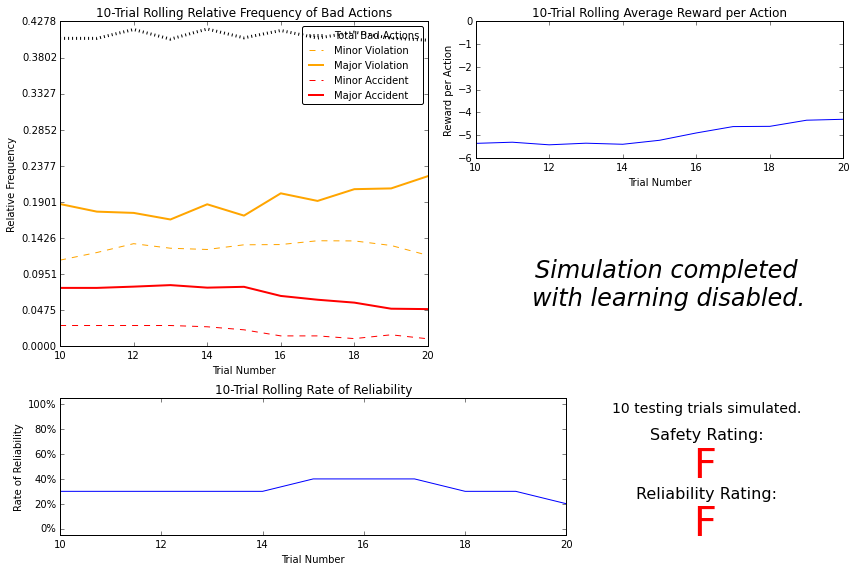

In [3]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

* Looking at the Relative Frequencies of Bad Actions plot, and making rough estimates: The relative frequency of bad actions hovers around 0.4, so nearly 40% of all actions are considered bad actions. Nearly half of the bad actions are major violations. All accidents (both minor and major) account for around 20% - 25% of all bad decisions, with major accidents being 3 to 4 times more frequent than minor accidents.
* The rate of reliability is not zero because the random-driving agent reaches its destination by chance in some trials (2, mostly 3, and even in one occasion 4, out of 10) since the grid is relatively small.
* The Average Reward per Action plot shows that the agent has been penalized heavily showing negative rewards for all trials hovering around -4.8.
* I would argue that the outcome of results have in all cases distributions that may very well be considered uniform, so there is no significant change in the results as the number of trials increases.
* With both reliability and safety graded with F, this random-driver is the least safe and least reliable Smartcab there could be, without considering an outright malicious agent that has defined goals of being unreliable and unsafe. So there is only room for improvement from now on.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**

'`waypoint`' and '`deadline`' are relevant to _efficiency_. The '`waypoint`' is defined in `planner.py` "based on current heading, location, intended destination and L1 distance from destination". This piece of information is necessary to the agent to be able to reliably reach the destination since it provides information about how to get closer to the goal. The '`deadline`', which is provided by the environment, is the number of rounds left to reach the destination. In order to account for efficiency, or reliability, the waypoint is enough information.

'`inputs`' is a dictionary containing four features; `light`, `left`, `right`, and `oncoming`. Since these are the sensors that allow the Smartcab to navigate the environment abiding the traffic rules, these are important for the driving agent to learn to avoid violations or accidents; thus these are important for _safety_. However, not all are absolutely necessary to ensure a satisfactory level of _safety_. `light` is necessary to stop when going forward and left. `right` is not necessary, and can be thought of as taken into accaount by `light`. `left` is necessary when the `waypoint` is turning right and `light` is red. `oncoming` is necessary when the `waypoint` is turning left, because in this case it's only safe to turn left if the `oncoming` traffic intended direction is taken into consideration.  

So the state is set to be a tuple of '`waypoint`', '`inputs['light']`', '`inputs['left']`', and '`inputs['oncoming']`'.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

Having in mind that we need to define a state space that takes into account both safety and reliability in the most efficient way, we have defined above a state with four variables. Let's first analyze each of these:

'`waypoint`' is a list of directions the Smartcab can take, namely: forward, left, or right.

'`inputs['light']`' which can be either red or green. 

'`inputs['oncoming']`', and '`inputs['left']`', are both the intended directions of travel for vehicles across the intersection, and to the left, so for each there can be any of four possibilities, namely; left, right, forward, or none. 

Thus the state space is:  
3 \* 2 \* 4 \* 4 = 96.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

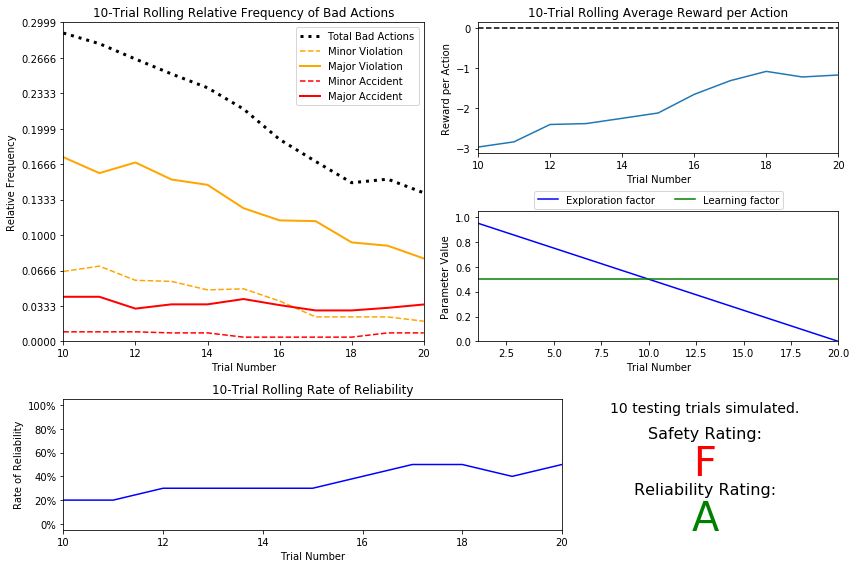

In [2]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

* The rate of reliability for the default learning agent is still pretty flat and around the same values as for the previous basic non-learning agent. The *safety rating* is still an 'F'.

* There are a total of 20 trainig trails and 10 testing trials. Given that epsilon is only relevant during training, and that is reduced by 0.05 each trial, there are exactly 20 trials before epsilon becomes 0 starting at a value of 1. This means that the first training trial has epsilon 0.95 (allowing almost only exploration by randomization), and training trial twentieth has epsilon 0 (only exploitation of Q values). This makes sense because at the beginning we need to explore to fetch and update Q values for as many states as we can explore, and as time goes by, it is smart to start reinforcing our policy i.e. our sequence of actions, and for this we need to take into account our Q values. In the parameter chart this exploration factor (epsilon) decays linearly, the learning factor (alpha) is constant at 0.5.

* The exploration factor is plotted, as expected. It starts very close to 1, at trial 10 is 0.5, and at trial 20 is zero.

* The relative frequency of Total Bad Actions decreased noticeably compared with the non-learning basic agent. Nonetheless, Minor Accidents and Major Accidents lack improvement and seem quiet falt.

* Safety rating did not improve, and kept an 'F' rating. Reliability rating did improve to 'A'. There still room for improvement, mostly in safety.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

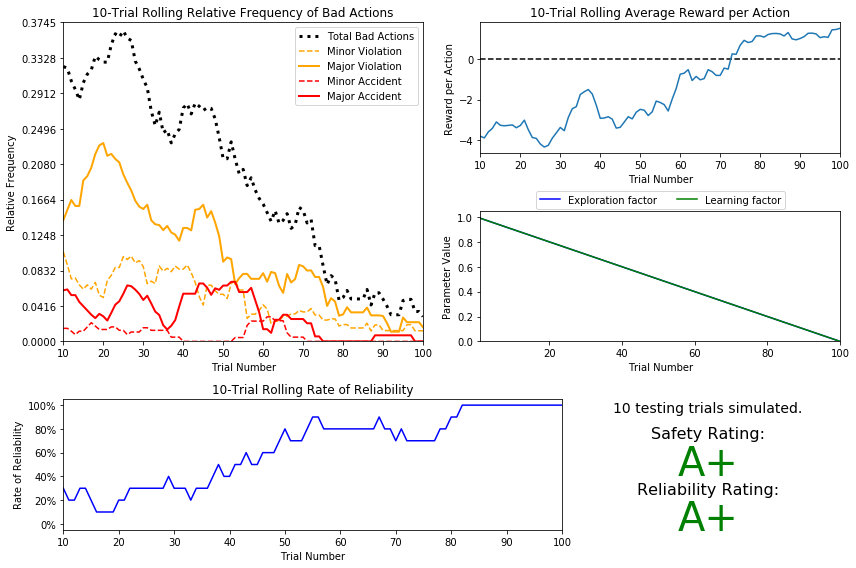

In [2]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

* The decaying function for the exploration factor, epsilon, was a linear decay, decreasing 0.01 every trial given that the training trials were increased to 100 in order to have an epsilon value that converges to zero at the end of training.

* To ensure learning in both safety and reliability, the training trials were incremented from 20 to 100. Testing trials were left at 10. In the Rate of Reliability plot, 100% is achieved around trial 82.

* The learning rate was also made linearly decaying, in the same fashion as epsilon. This made sense because as we decrease exploration (decrese epsilon), it's also reasonable to decrease the weight that the reward has in the updating of the Q values, and more weight should be put to the importance of previous Q values; i.e. in the beginning when the agent doesn't know anything about the world, it's better to explore confering more value to the rewards; at the end when there is a focus in exploitation, it's better to have more weight on previous Q values when updating them. Having said that, in this case it's worth mentioning, as observed in the first review, that the nature of how rewards are assigned is deterministic; a (state, action) pair will always get a consistent reward. So alpha is arbitrary because regardless of how rewards are updated (how much the agent remembers from a given experience), it's learning the optimal policy.  

* The improvement is optimal since both performance measures reached the best possible scores.

* The improved driving agent did successfully learned both safety and reliability.

* The improved driving agent achieved ratings of A+ in both _safety_ and _reliability_. 100 trials for training seems a reasonable increase in training given the space state. I am satisfied.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 

1. The optimal policy for _reliability_ is to follow the `waypoint`.  
    The optimal policy for _safety_ is to avoid _bad actions_,  That is, to abide the traffic laws:  

    Stopping at red `light` if the `waypoint` is _forward_ or _left_.  
    Going ahead at green `light` if the `waypoint` is _forward_ or _right_.  
    Going ahead if `waypoint` is _left_ and `oncoming` is _none_.  
    Going ahead at red `light` if `waypoint` is _right_ and `left` is not _forward_.  

    The optimal global policy is combining these two. Since the state is a tuple of `waypoint`, `light`, `left` and `oncoming`, all the possible combinations for both  _reliability_ and _safety_ are taken into account.  
<br/>
2. The states are associated to action values that are consistent to the optimal policy.
<br/>
<br/>
3. Here are four examples; let's recall that state = (waypoint, inputs['light'], inputs['left'], inputs['oncoming'])


    State:
    ('forward', 'red', 'right', 'forward')
    Action values:
     -- forward : -10.16
     -- right : 0.00
     -- None : 1.66
     -- left : 0.00
     
     Waypoint is forward, but light is red. Doing nothing gives the maximum reward. 


    State:
    ('forward', 'green', 'left', 'right')
    Action values:
     -- forward : 1.95
     -- right : 0.00
     -- None : -3.62
     -- left : 0.00

    Waypoint is forward, and light is green. Going forward gives the maximum reward.


    State:
    ('left', 'red', None, None)
    Action values:
     -- forward : -9.58
     -- right : 0.93
     -- None : 2.05
     -- left : -10.17

    Waypoint is left, and oncoming is None. However, light is red, thus doing nothing gives the maximum reward.
    

    State:
    ('right', 'red', None, 'left')
    Action values:
     -- forward : -26.43
     -- right : 1.70
     -- None : 0.58
     -- left : -10.91
     
     Waypoint is right, light is red, and left is None. Even though the light is red, going right gives the maximum reward 
     since there is no vehicle on the right.

4.Let's examine the following case:

    State:
    ('left', 'red', 'left', 'forward')
    Action values:
     -- forward : -16.37
     -- right : 1.18
     -- None : 0.00
     -- left : -2.74
     
    Waypoint is left, and light is red; however turning right has the maximum reward. The vehicle in the left is turning 
    left, thus no accident is bound to occur, but the agent is getting farther from its destination. 

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

1. The fact that the smartcab can 'sense' the `waypoint` allows to follow a correct direction in every step without taking into account the future. The agent only knows the present state; since the environment is dynamic, in the sense that every intersection has a different reading in every step, there is no way for the agent to know the next state over.

2. The initial position of the smartcab, as well as its destination change every trial. This means that the optimal policy is not a sequence of states. Every (state, action) pair is enough; this is a deterministic environment.

Taking into account future rewards in this setting doesn't make sense.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.